## Notebook-Dokumentation
- Aggregiert Crash-Zahlen nach Stunde/Wochentag/Monat, Fokus auf Cyclist-bezogene Fälle.
- Zeigt Verletzungs-/Todesfälle im Zeitverlauf und Tagesprofil.
- Enthält Filterung auf relevante Kategorien, um Verzerrungen zu vermeiden.


Lädt Crash-CSV, harmonisiert Spaltennamen, baut crash_datetime und Zeitdimensionen, filtert auf Cyclist-Involved; Ergebnis-LazyFrame crashes.

In [2]:
from pathlib import Path
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
pl.Config.set_tbl_rows(500)

SCHEMA = {
    "CRASH DATE": pl.Utf8,
    "CRASH TIME": pl.Utf8,
    "BOROUGH": pl.Utf8,
    "ZIP CODE": pl.Utf8,
    "LATITUDE": pl.Float64,
    "LONGITUDE": pl.Float64,
    "LOCATION": pl.Utf8,
    "ON STREET NAME": pl.Utf8,
    "CROSS STREET NAME": pl.Utf8,
    "OFF STREET NAME": pl.Utf8,
    "NUMBER OF PERSONS INJURED": pl.Int64,
    "NUMBER OF PERSONS KILLED": pl.Int64,
    "NUMBER OF PEDESTRIANS INJURED": pl.Int64,
    "NUMBER OF PEDESTRIANS KILLED": pl.Int64,
    "NUMBER OF CYCLIST INJURED": pl.Int64,
    "NUMBER OF CYCLIST KILLED": pl.Int64,
    "NUMBER OF MOTORIST INJURED": pl.Int64,
    "NUMBER OF MOTORIST KILLED": pl.Int64,
    "CONTRIBUTING FACTOR VEHICLE 1": pl.Utf8,
    "CONTRIBUTING FACTOR VEHICLE 2": pl.Utf8,
    "CONTRIBUTING FACTOR VEHICLE 3": pl.Utf8,
    "CONTRIBUTING FACTOR VEHICLE 4": pl.Utf8,
    "CONTRIBUTING FACTOR VEHICLE 5": pl.Utf8,
    "COLLISION_ID": pl.Int64,
    "VEHICLE TYPE CODE 1": pl.Utf8,
    "VEHICLE TYPE CODE 2": pl.Utf8,
    "VEHICLE TYPE CODE 3": pl.Utf8,
    "VEHICLE TYPE CODE 4": pl.Utf8,
    "VEHICLE TYPE CODE 5": pl.Utf8,
}

DATA_PATH = Path("../../raw_data/nypd/Motor_Vehicle_Collisions_Crashes.csv")
scan = pl.scan_csv(DATA_PATH, schema=SCHEMA, infer_schema_length=2000, null_values=[""])
rename_map = {name: name.lower().replace(" ", "_") for name in scan.columns}
scan = scan.rename(rename_map)
scan = scan.with_columns(
    pl.concat_str([pl.col("crash_date"), pl.col("crash_time")], separator=" ")
    .str.strptime(pl.Datetime, "%m/%d/%Y %H:%M", strict=False)
    .alias("crash_datetime")
)
crashes = (
    scan.filter(pl.col("crash_datetime").is_not_null())
    .with_columns(
        [
            pl.col("crash_datetime").dt.hour().alias("hour"),
            pl.col("crash_datetime").dt.weekday().alias("weekday"),
            pl.col("crash_datetime").dt.strftime("%Y-%m").alias("year_month"),
            pl.col("crash_datetime").dt.year().alias("year"),
        ]
    )
)
crashes = crashes.filter(
        pl.col("crash_datetime").is_not_null()
        & (
            (pl.col("number_of_cyclist_injured") > 0)
            | (pl.col("number_of_cyclist_killed") > 0)
        )
    )


/var/folders/3d/gm4l_8mn4_59wxskbwlby73w0000gn/T/ipykernel_16070/927503515.py:43: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  rename_map = {name: name.lower().replace(" ", "_") for name in scan.columns}


Aggregiert Crashes pro Stunde (Tagesprofil).

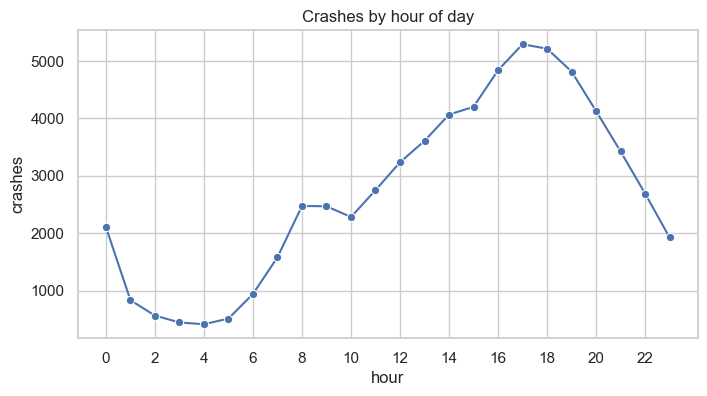

In [4]:
hourly = (
    crashes.group_by("hour")
    .agg(pl.len().alias("crashes"))
    .sort("hour")
    .collect()
    .to_pandas()
)
plt.figure(figsize=(8, 4))
sns.lineplot(data=hourly, x="hour", y="crashes", marker="o")
plt.xticks(range(0, 24, 2))
plt.title("Crashes by hour of day")
plt.show()


Berechnet Crashes pro Stunde und Jahr und zeigt Heatmap (Stunde x Jahr).

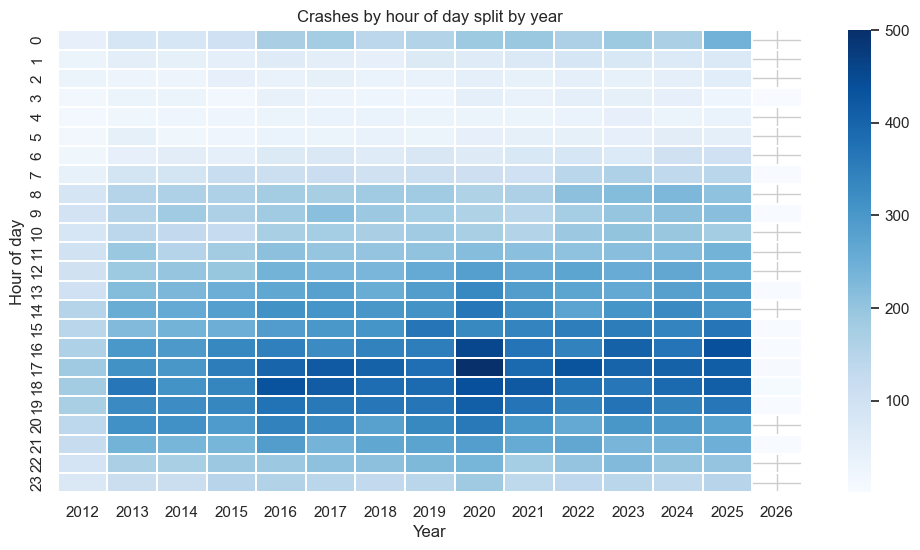

In [5]:
hourly_by_year = (
    crashes.group_by(["hour", "year"])
    .agg(pl.len().alias("crashes"))
    .sort(["hour", "year"])
    .collect()
    .to_pandas()
)
hourly_by_year_pivot = hourly_by_year.pivot(index="hour", columns="year", values="crashes")
plt.figure(figsize=(12, 6))
sns.heatmap(hourly_by_year_pivot, cmap="Blues", linewidths=0.3)
plt.title("Crashes by hour of day split by year")
plt.ylabel("Hour of day")
plt.xlabel("Year")
plt.show()

Aggregiert Verletzte pro Stunde (Schwereverlauf über den Tag).

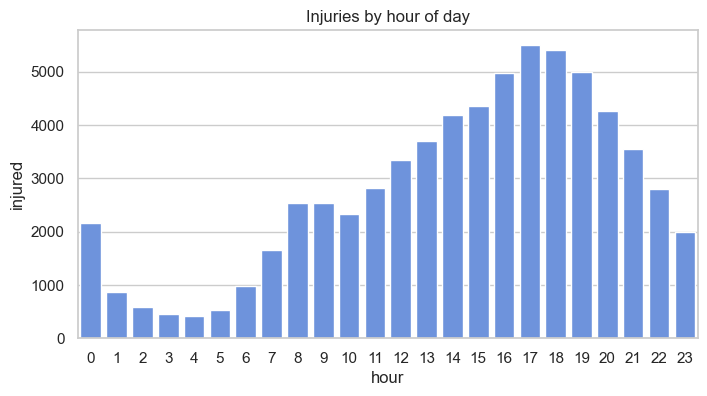

In [6]:
# Injuries by hour of day
hourly_injuries = (
    crashes.group_by("hour")
    .agg(pl.sum("number_of_persons_injured").alias("injured"))
    .sort("hour")
    .collect()
    .to_pandas()
)
plt.figure(figsize=(8, 4))
sns.barplot(data=hourly_injuries, x="hour", y="injured", color="#5b8def")
plt.title("Injuries by hour of day")
plt.show()


Berechnet Verletzte pro Stunde und Jahr, Heatmap zur Jahresdifferenzierung.

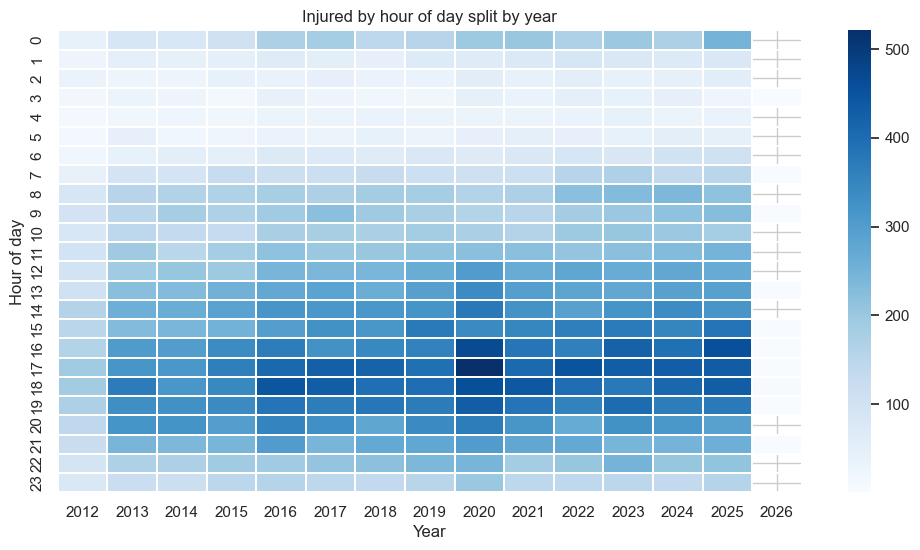

In [7]:
hourly_by_year = (
    crashes.group_by(["hour", "year"])
    .agg(pl.sum("number_of_persons_injured").alias("injured"))
    .sort(["hour", "year"])
    .collect()
    .to_pandas()
)
hourly_by_year_pivot = hourly_by_year.pivot(index="hour", columns="year", values="injured")
plt.figure(figsize=(12, 6))
sns.heatmap(hourly_by_year_pivot, cmap="Blues", linewidths=0.3)
plt.title("Injured by hour of day split by year")
plt.ylabel("Hour of day")
plt.xlabel("Year")
plt.show()

Aggregiert Crashes pro Wochentag (Wochentagsprofil).

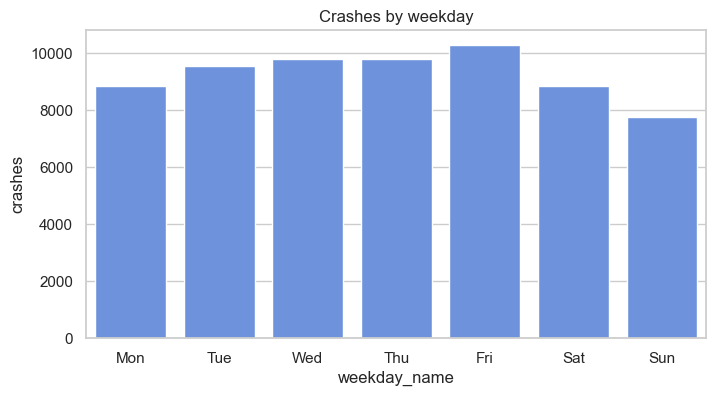

In [18]:
weekday = (
    crashes.group_by("weekday")
    .agg(pl.len().alias("crashes"))
    .sort("weekday")
    .collect()
    .to_pandas()
)
weekday_names = {0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"}
weekday["weekday_name"] = weekday["weekday"].map(lambda w: weekday_names.get((w - 1) % 7))
plt.figure(figsize=(8, 4))
sns.barplot(
    data=weekday,
    x="weekday_name",
    y="crashes",
    color="#5b8def",
    order=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
)
plt.title("Crashes by weekday")
plt.show()


Berechnet Crashes pro Wochentag und Jahr, Heatmap mit Wochentagslabels.

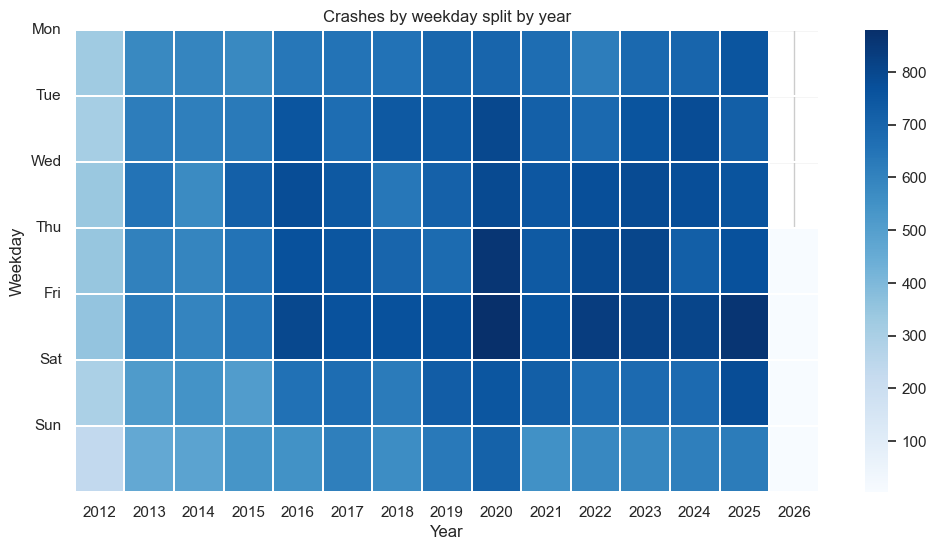

In [17]:
weekday_by_year = (
    crashes.group_by(["weekday", "year"])
    .agg(pl.len().alias("crashes"))
    .sort(["weekday", "year"])
    .collect()
    .to_pandas()
)

weekday_by_year_pivot = (
    weekday_by_year.pivot(index="weekday", columns="year", values="crashes")
    .reindex(weekday_order)
)

plt.figure(figsize=(12, 6))
sns.heatmap(weekday_by_year_pivot, cmap="Blues", linewidths=0.3)
plt.title("Crashes by weekday split by year")
plt.ylabel("Weekday")
plt.xlabel("Year")
plt.yticks(
    ticks=range(len(weekday_by_year_pivot.index)),
    labels=[weekday_names.get((i - 1) % 7, str(i)) for i in weekday_by_year_pivot.index],
    rotation=0,
)
plt.show()

Aggregiert Crashes pro Jahr und Monat, Heatmap (Monat x Jahr) für saisonale Muster.

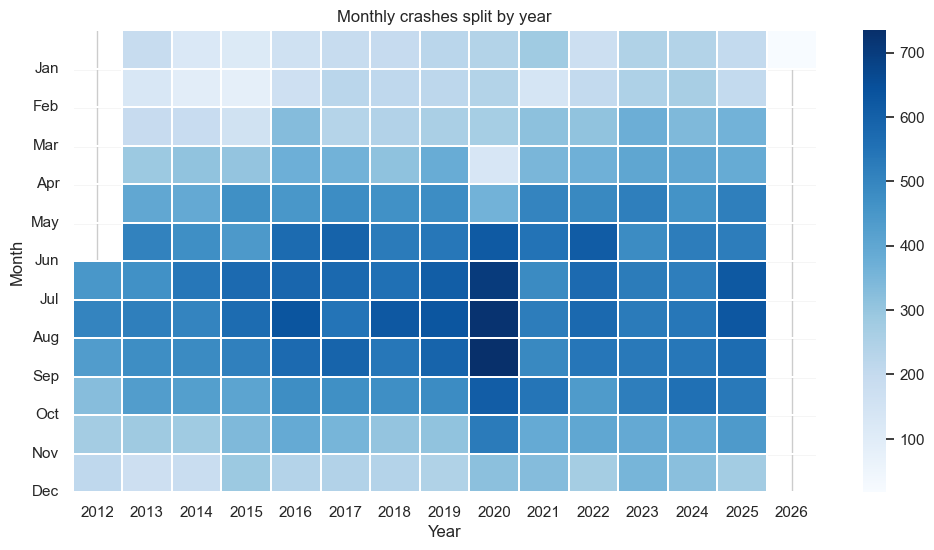

In [19]:
monthly_by_year = (
    crashes.group_by(["year", "year_month"])
    .agg(pl.len().alias("crashes"))
    .sort(["year", "year_month"])
    .collect()
    .to_pandas()
)
monthly_by_year["month"] = monthly_by_year["year_month"].str[5:7].astype(int)

monthly_by_year_pivot = (
    monthly_by_year.pivot(index="month", columns="year", values="crashes")
    .reindex(range(1, 13))
)

plt.figure(figsize=(12, 6))
sns.heatmap(monthly_by_year_pivot, cmap="Blues", linewidths=0.3)
plt.title("Monthly crashes split by year")
plt.ylabel("Month")
plt.xlabel("Year")
plt.yticks(
    ticks=range(1, 13),
    labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
    rotation=0,
)
plt.show()
